In [ ]:
import os
import glob
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import albumentations
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

In [2]:
BASE_MASK_PATH = '/opt/ml/input/data/'
TRAIN_MASK_IMAGE_PATH = os.path.join(BASE_MASK_PATH, 'train/images/')
TRAIN_MASK_LABEL_PATH = os.path.join(BASE_MASK_PATH, 'train/train.csv')
TEST_MASK_IMAGE_PATH = os.path.join(BASE_MASK_PATH, 'test/images/')
TEST_MASK_LABEL_PATH = os.path.join(BASE_MASK_PATH, 'test/info.csv')

# Data Analysis

## csv 파일 처리

In [51]:
train_data = pd.read_csv(TRAIN_MASK_LABEL_PATH)
train_data['class'] = 0
train_data

,id,gender,race,age,path,class
0,000001,female,Asian,45,000001_female_Asian_45,0
1,000002,female,Asian,52,000002_female_Asian_52,0
2,000004,male,Asian,54,000004_male_Asian_54,0
3,000005,female,Asian,58,000005_female_Asian_58,0
4,000006,female,Asian,59,000006_female_Asian_59,0
...,...,...,...,...,...,...
2695,006954,male,Asian,19,006954_male_Asian_19,0
2696,006955,male,Asian,19,006955_male_Asian_19,0
2697,006956,male,Asian,19,006956_male_Asian_19,0
2698,006957,male,Asian,20,006957_male_Asian_20,0


In [52]:
len(train_data['path'].unique())

2700

In [53]:
for i, row in train_data.iterrows():
    if row['age'] < 30:
        if row['gender'] == 'female':
            notwear_class = 15
            incorrect_class = 9
            wear_class = 3
        elif row['gender'] == 'male':
            notwear_class = 12
            incorrect_class = 6
            wear_class = 0  

    elif row['age'] >= 60:
        if row['gender'] == 'female':
            notwear_class = 17
            incorrect_class = 11
            wear_class = 5
        elif row['gender'] == 'male':
            notwear_class = 14
            incorrect_class = 8
            wear_class = 2   

    else:
        if row['gender'] == 'female':
            notwear_class = 16
            incorrect_class = 10
            wear_class = 4
        elif row['gender'] == 'male':
            notwear_class = 13
            incorrect_class = 7
            wear_class = 1   
    
    path = row['path']
    #Not wear
    notwear_data = row
    notwear_data['path'] = path + '/normal.jpg'
    notwear_data['class'] = notwear_class
    train_data = train_data.append(notwear_data, ignore_index=True)
    #Incorrect 
    incorrect_data = row
    incorrect_data['path'] = path + '/incorrect_mask.jpg'
    incorrect_data['class'] = incorrect_class
    train_data = train_data.append(incorrect_data, ignore_index=True)
    #Wear
    for n in range(1,6):
        wear_data = row
        wear_data['path'] = path + '/mask' + str(n) + '.jpg'
        wear_data['class'] = wear_class
        train_data = train_data.append(wear_data, ignore_index=True)

In [32]:
train_pre_data = train_data[2700:]
train_pre_data.reset_index(drop=True, inplace=True)
train_pre_data.to_csv('/opt/ml/input/data/train/train_pre.csv', index=False)

NameError: name 'train_data' is not defined

In [33]:
train_pre_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18900 entries, 0 to 18899
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      18900 non-null  object
 1   gender  18900 non-null  object
 2   race    18900 non-null  object
 3   age     18900 non-null  int64 
 4   path    18900 non-null  object
 5   class   18900 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 886.1+ KB


## Image 파일 처리

In [317]:
image = glob.glob('/opt/ml/input/data/train/crop_images/' + '*/*')

In [314]:
image[0].split('.')[0] + '.jpg'

'/opt/ml/input/data/train/crop_images/001210_male_Asian_25/mask4.jpg'

In [316]:
for img in image:
    print(img)
    im1 = Image.open(img).convert("RGB")
    im1.save(img.split('.')[0] + '.jpg')

In [321]:
im = Image.open('/opt/ml/input/data/train/crop_images/006359_male_Asian_18/mask4.jpg')
im

NameError: name 'Iamge' is not defined

# CutMix


In [37]:
train_data = pd.read_csv('/opt/ml/input/data/train/train.csv')
train_pre_data = pd.read_csv('/opt/ml/input/data/train/train_pre.csv')
train_pre_data['gender'] = train_pre_data['gender'].map({'male':0, 'female':1})
train_pre_data.head()

,id,gender,race,age,path,class
0,000001,1,Asian,45,000001_female_Asian_45/normal.jpg,16
1,000001,1,Asian,45,000001_female_Asian_45/incorrect_mask.jpg,10
2,000001,1,Asian,45,000001_female_Asian_45/mask1.jpg,4
3,000001,1,Asian,45,000001_female_Asian_45/mask2.jpg,4
4,000001,1,Asian,45,000001_female_Asian_45/mask3.jpg,4


In [76]:
import random
data_folder = "/opt/ml/input/data/train/crop_images/"
filenames = glob.glob(f"{data_folder}*/*.jpg")
random.shuffle(filenames)

image_batch = filenames[:5]
image_batch_labels = []
for i in image_batch:
    labels = train_pre_data[train_pre_data['path']==(i.split('/')[-2] + "/" +i.split('/')[-1])]['class']
    image_batch_labels.append(int(labels.values))
print(image_batch, image_batch_labels)


['/opt/ml/input/data/train/crop_images/003832_male_Asian_55/normal.jpg', '/opt/ml/input/data/train/crop_images/006959_male_Asian_19/mask4.jpg', '/opt/ml/input/data/train/crop_images/006684_male_Asian_19/mask1.jpg', '/opt/ml/input/data/train/crop_images/001005_male_Asian_24/mask3.jpg', '/opt/ml/input/data/train/crop_images/006429_female_Asian_18/incorrect_mask.jpg'] [13, 0, 0, 0, 9]


In [93]:
onehot_encoded = list()
for value in image_batch_labels:
	letter = [0 for _ in range(18)]
	letter[value] = 1
	onehot_encoded.append(letter)
onehot_image_labels = np.array(onehot_encoded)
onehot_image_labels

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

In [221]:
class TrainDataset(Dataset):
    def __init__(self, img_paths, labels, transform):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        x = Image.open(self.img_paths[idx])
        y = self.labels[idx]
  
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.img_paths)

In [222]:
transform= transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        ])

In [223]:
mask_dataset = TrainDataset(image_batch, image_batch_labels, transform)

In [224]:
num_workers = 1
batch_size = 5

mask_train_dataloader = DataLoader(
    mask_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
    )


In [226]:
images, labels = next(iter(mask_train_dataloader))
images.shape

torch.Size([5, 3, 128, 128])

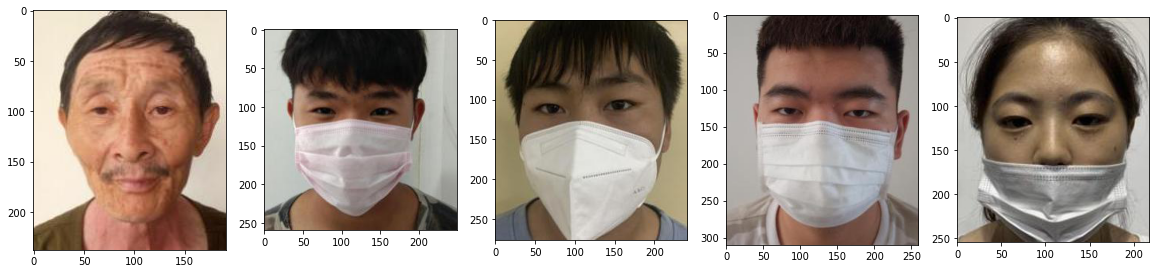

In [309]:
plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(Image.open(image_batch[i]))
plt.show()

In [247]:
def rand_bbox(size, lam): # size : [Batch_size, Channel, Width, Height]
    W = size[2] 
    H = size[3] 
    cut_rat = np.sqrt(1. - lam)  # 패치 크기 비율
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)  

   	# 패치의 중앙 좌표 값 cx, cy
    cx = np.random.randint(W)
    cy = np.random.randint(H)
		
    # 패치 모서리 좌표 값 
    bbx1 = 0
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = W
    bby2 = np.clip(cy + cut_h // 2, 0, H)
   
    return bbx1, bby1, bbx2, bby2

tensor([ 0.0000,  0.8438,  1.2188, 11.7812,  8.1562])


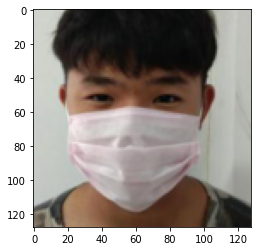

In [308]:
# plt.figure(figsize=(10,10))
for ind, (images, labels) in enumerate(mask_train_dataloader):
    lam = np.random.beta(1.0, 1.0)
    rand_index = torch.randperm(images.size()[0])
    target_a = labels # 원본 이미지 label
    target_b = labels[rand_index] # 패치 이미지 label       
    bbx1, bby1, bbx2, bby2 = rand_bbox(images.size(), lam)
    image_batch_updated = images

    image_batch_updated[:, bbx1:bbx2, bby1:bby2, :] = images[rand_index, bbx1:bbx2, bby1:bby2, :]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.size()[-1] * images.size()[-2]))
    label = target_a * lam + target_b * (1. - lam)
    
    # plt.subplot(1,5,ind+1)
    plt.imshow(image_batch_updated[ind].squeeze().permute(1,2,0))
    print(label)
plt.show()

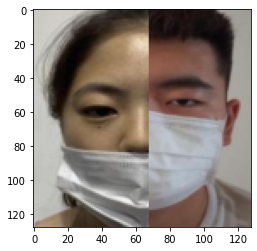

In [274]:
# plt.figure(figsize=(10,10))
for ind, (images, labels) in enumerate(mask_train_dataloader):
    lam = np.random.beta(1.0, 1.0)
    rand_index = torch.randperm(images.size()[0])
    target_a = labels # 원본 이미지 label
    target_b = labels[rand_index] # 패치 이미지 label       
    bbx1, bby1, bbx2, bby2 = rand_bbox(images.size(), lam)
    image_batch_updated = images

    image_batch_updated[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.size()[-1] * images.size()[-2]))
    label = target_a * lam + target_b * (1. - lam)
    
    # plt.subplot(1,5,ind+1)
    plt.imshow(image_batch_updated[ind].squeeze().permute(1,2,0))
plt.show()

# Model

In [8]:
from torchvision import models
resnet = models.resnet18(pretrained=True)
resnet.fc

Linear(in_features=512, out_features=1000, bias=True)

In [9]:
resnet.fc = torch.nn.Linear(
            in_features=512, 
            out_features=18, 
            bias=True)

In [10]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
import torch.nn as nn
classifier = nn.Sequential(nn.Linear(1792, 1024),
                    nn.ReLU(),
                    nn.Linear(1024, 512),
                    nn.ReLU(),
                    nn.Linear(512, 256),
                    nn.ReLU(),
                    nn.Linear(256, 18),
                    )
from efficientnet_pytorch import EfficientNet
efficient = EfficientNet.from_pretrained('efficientnet-b4')
efficient._fc = classifier
efficient

# 데이터 분석

In [12]:
train_pre_data = pd.read_csv('/opt/ml/input/data/train/train_pre.csv')
train_pre_data.head()

,id,gender,race,age,path,class
0,000001,female,Asian,45,000001_female_Asian_45/normal.jpg,16
1,000001,female,Asian,45,000001_female_Asian_45/incorrect_mask.jpg,10
2,000001,female,Asian,45,000001_female_Asian_45/mask1.jpg,4
3,000001,female,Asian,45,000001_female_Asian_45/mask2.jpg,4
4,000001,female,Asian,45,000001_female_Asian_45/mask3.jpg,4


In [58]:
print("30 >  Age      : {}".format(len(train_pre_data[train_pre_data['age'] < 30])))
print("30 <= Age < 60 : {}".format(len(train_pre_data[ (train_pre_data['age'] >= 30) & (train_pre_data['age'] < 60) ] )))
print("60 <= Age      : {}".format(len(train_pre_data[train_pre_data['age'] >= 60])))
print(Counter(train_pre_data['gender']))
print(Counter(train_pre_data['class']))

30 >  Age      : 8967
30 <= Age < 60 : 8589
60 <= Age      : 1344
Counter({'female': 11606, 'male': 7294})
Counter({4: 4085, 3: 3660, 0: 2745, 1: 2050, 16: 817, 10: 817, 15: 732, 9: 732, 12: 549, 6: 549, 5: 545, 2: 415, 13: 410, 7: 410, 17: 109, 11: 109, 14: 83, 8: 83})


# K-fold

In [17]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits = 5, shuffle =True, random_state=42)
for train, test in kfold.split(train_pre_data['path'], train_pre_data['class']):
    print(train, test)

[    0     1     2 ... 18897 18898 18899] [   11    12    13 ... 18885 18889 18892]
[    1     2     3 ... 18897 18898 18899] [    0     9    15 ... 18887 18890 18891]
[    0     1     3 ... 18895 18898 18899] [    2     5     7 ... 18894 18896 18897]
[    0     1     2 ... 18896 18897 18899] [    6    10    16 ... 18883 18893 18898]
[    0     2     5 ... 18896 18897 18898] [    1     3     4 ... 18888 18895 18899]


# FaceCrop

In [310]:
import os
import glob

TRAIN_IMGS_DATASET_PATH = "/content/input/data/train/images"
EVAL_IMGS_DATASET_PATH = "/content/input/data/eval/images"

list_individuals = glob.glob(os.path.join(TRAIN_IMGS_DATASET_PATH, "*"))